# Desafio Codenation - AceleraDev Data Science

In [1]:
# Importando todas as bibliotecas a serem usadas no projeto
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
import sklearn.metrics as metrics

### Parte 1 - Conhecendo o dataset

Esse dataset é esparso, contendo 167 colunas, portanto não podemos trabalhar com ele dessa forma. Será preciso identificar quais as informações mais importantes a serem utilizadas na predição.

In [2]:
# Importando os dados de treino e de teste
data_train = pd.read_csv('datasets/train.csv', sep=",",encoding="utf-8")
data_test = pd.read_csv('datasets/test.csv', sep=",",encoding="utf-8")

Para realizar a predição é necessário pré-processar esse dataset e verificar quais são as features mais relevantes para esse treinamento:

In [3]:
data_train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


Irei verificar a correlação dessas informações para ajudar a identificar quais features podem ser mais relevantes para a predição:

***A função do coeficiente de correlação é determinar qual é a intensidade da relação que existe entre conjuntos de dados ou informações conhecidas. O valor do coeficiente de correlação pode variar entre -1 e 1 e o resultado obtido define se a correlação é negativa ou positiva***

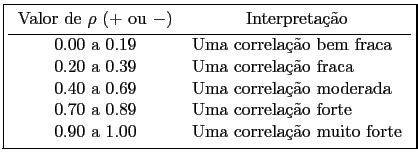

In [4]:
Image("imagens/correlacao.jpeg")

Irei portanto filtrar features de correlações mais relevantes a nota de matemática:

In [5]:
correlacoes = data_train.corr()

In [6]:
features = correlacoes[(correlacoes['NU_NOTA_MT'] <= -0.3) | (correlacoes['NU_NOTA_MT'] >= 0.3) & (correlacoes['NU_NOTA_MT'] < 1.0)]['NU_NOTA_MT']
features

TP_DEPENDENCIA_ADM_ESC    0.373233
NU_NOTA_CN                0.584941
NU_NOTA_CH                0.529594
NU_NOTA_LC                0.494695
NU_NOTA_COMP2             0.335638
NU_NOTA_COMP3             0.350307
NU_NOTA_COMP4             0.342282
NU_NOTA_COMP5             0.343337
NU_NOTA_REDACAO           0.379376
Name: NU_NOTA_MT, dtype: float64

Apesar de 0.3 ainda ser um valor baixo para o coeficiente de correlação dos dados, irei testar com esse valor por permitir que mais features além das notas de Ciências Naturais, Humanas e Linguagens e Códigos possam ser usadas:

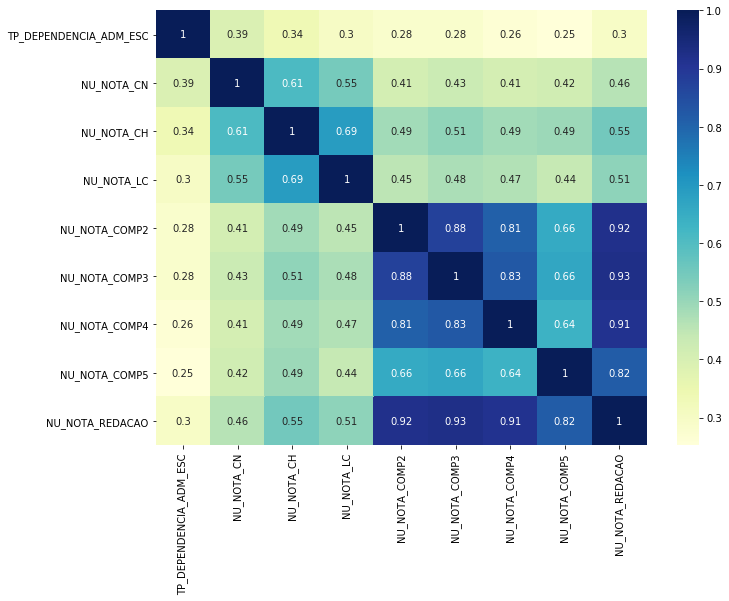

In [7]:
# Plotando as correlações em um heatmap
features_list = features.index.to_list()
corr = data_train[features_list].corr()
ax = plt.subplots(figsize=(11, 8))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10},cmap="YlGnBu")

Precisamos verificar agora se essas features possuem valores nulos ou vazios:

In [8]:
data_train[features_list].isnull().sum()

TP_DEPENDENCIA_ADM_ESC    9448
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
NU_NOTA_COMP2             3597
NU_NOTA_COMP3             3597
NU_NOTA_COMP4             3597
NU_NOTA_COMP5             3597
NU_NOTA_REDACAO           3597
dtype: int64

In [9]:
data_train['NU_NOTA_MT'].isnull().sum()

3597

Irei adicionar a nota de matemática a lista de features a ser processada para que o algoritmo não seja treinado com valores nulos: 

In [10]:
features_list.append('NU_NOTA_MT')

Podemos fazer alguns testes aqui: 
- 1 - Preencher os valores nulos com zeros
- 2 - Preencher os valores com a média dos valores

OBS: O dataset já possui poucos registros, portanto a remoção de registros nulos não será uma opção viável

### Preencher com zeros

In [11]:
df1_train = data_train.copy()
df1_test = data_test.copy()

In [12]:
def zeroFill(data):
    for item in features_list:
        data[item] = data[item].fillna(0)
    return data

In [13]:
df1_train = zeroFill(df1_train)

In [14]:
df1_test = df1_test.fillna(0)

### Preencher com a média

In [15]:
df2_train = data_train.copy()
df2_test = data_test.copy()

In [16]:
def meanFill(data):
    for item in features_list:
        data[item] = data[item].fillna(data[item].mean())
    return data

In [17]:
df2_train = meanFill(df2_train)

In [18]:
df2_test = df1_test.fillna(df2_test.mean())

### Testando alguns algoritmos

Para esse problema, irei testar os seguintes algoritmos: </br>
- **LinearRegression:** A regressão linear é um modelo estatístico que examina a relação linear entre duas variáveis (regressão linear simples) ou mais (regressão linear múltipla) - uma variável dependente e variável (s) independente (s). O relacionamento linear basicamente significa que quando uma (ou mais) variáveis independentes aumentam (ou diminuem), a variável dependente também aumenta (ou diminui)<br>
- **KNeighborsRegressor:** O algoritmo KNN pode ser usado para problemas de classificação e regressão. O algoritmo KNN usa 'similaridade de recurso' para prever os valores de quaisquer novos pontos de dados. Isso significa que o novo ponto recebe um valor com base na proximidade com os pontos no conjunto de treinamento.</br>
- **DecisionTreeRegressor:** A árvore de decisão constrói modelos de regressão ou classificação na forma de uma estrutura em árvore. Ele divide um conjunto de dados em subconjuntos cada vez menores e, ao mesmo tempo, uma árvore de decisão associada é desenvolvida de forma incremental. O resultado final é uma árvore com nós de decisão e nós de folha.</br>
- **GradientBoostRegressor:** "Boost" no aprendizado de máquina é uma maneira de combinar vários modelos simples em um único modelo composto. É também por isso que o reforço é conhecido como modelo aditivo, uma vez que modelos simples (também conhecidos como aprendizes fracos) são adicionados um de cada vez, mantendo inalteradas as árvores existentes no modelo. À medida que combinamos modelos cada vez mais simples, o modelo final completo se torna um preditor mais forte. O termo "gradiente" em "aumento de gradiente" vem do fato de o algoritmo usar descida de gradiente para minimizar a perda.</br>
- **RandomForestRegressor:** Também é um modelo que funciona através da técnica ensemble, que combina as previsões de vários algoritmos de aprendizado de máquina para fazer previsões mais precisas do que qualquer modelo individual. Esse modelo combina várias árvores de decisão que são executadas em paralelo. Não há interação entre essas árvores durante a construção das árvores. 

In [19]:
# Criando dataset de respostas
df_result = pd.DataFrame()

In [20]:
# Adicionando número de inscrição a ser salvo no arquivo de resposta final
df_result['NU_INSCRICAO'] = data_test['NU_INSCRICAO']

In [21]:
# Removendo a variável target
features_list.remove('NU_NOTA_MT')

#### Usando o dataset preenchido com zeros

In [22]:
def validaPerformanceModelos(pipelines,x_train,y_train):
    results = []
    names = []
    for name, model in pipelines:
        kfold = KFold(n_splits=5, random_state=21, shuffle=True)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

In [23]:
pipelines = []
pipelines.append(('LR', Pipeline([('Scaler', MinMaxScaler()),('LR',LinearRegression())])))
pipelines.append(('KNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('DTR', Pipeline([('Scaler', MinMaxScaler()),('DTR', DecisionTreeRegressor())])))
pipelines.append(('GBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('RFR', Pipeline([('Scaler', MinMaxScaler()),('RFR', RandomForestRegressor())])))

In [24]:
x_train = df1_train[features_list]
y_train = df1_train['NU_NOTA_MT']
x_test = df1_test[features_list]

In [25]:
validaPerformanceModelos(pipelines, x_train, y_train)

LR: -5101.872087 (135.658620)
KNN: -5041.330622 (39.766364)
DTR: -8286.775269 (315.776278)
GBM: -4052.143957 (48.027504)
RFR: -4340.556402 (59.310395)


Os algoritmos com a melhor performance foram o GradientBoostingRegressor e o RandomForestRegressor (possuem um valor de erro médio menor), portanto irei gerar os arquivos de resposta para testar no site do Codenation

- GradientBoostRegressor:

In [26]:
pipe_GBM = Pipeline([('scaler',  StandardScaler()),
            ('GradientBoostingRegressor', GradientBoostingRegressor())])

In [27]:
CV_pipe_GBM = RandomizedSearchCV(estimator = pipe_GBM, param_distributions = {},cv = 5,return_train_score=True, verbose=0)

In [28]:
CV_pipe_GBM.fit(x_train, y_train)
ypred = CV_pipe_GBM.predict(x_test)

/home/gabriela/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [29]:
df_result['NU_NOTA_MT'] = np.around(ypred,2)

In [30]:
df_result.to_csv('answer.csv', index=False, header=True)

De acordo com o teste no site do codenation, essa predição gerou um score de 93.63%

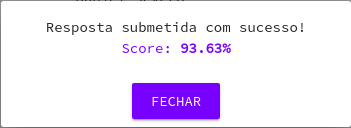

In [31]:
Image('imagens/score.png')

- RandomForestRegressor

In [32]:
pipe_RFR = Pipeline([('scaler',  StandardScaler()),
            ('RandomForestRegressor', RandomForestRegressor())])

In [33]:
CV_pipe_RFR = RandomizedSearchCV(estimator = pipe_RFR, param_distributions = {},cv = 5,return_train_score=True, verbose=0)

In [34]:
x_train = df1_train[features_list]
y_train = df1_train['NU_NOTA_MT']
x_test = df1_test[features_list]

In [35]:
CV_pipe_RFR.fit(x_train, y_train)
ypred2 = CV_pipe_RFR.predict(x_test)

/home/gabriela/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [36]:
df_result['NU_NOTA_MT'] = np.around(ypred2,2)

In [37]:
df_result.to_csv('answer2.csv', index=False, header=True)

Essa predição conforme o teste no site do Codenation já gerou um score menor, com a taxa de acertos de 93.46%

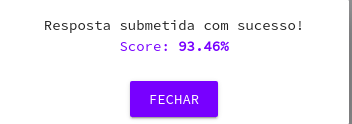

In [38]:
Image('imagens/score2.png')

#### Usando o dataset preenchido com a média

In [39]:
x_train = df2_train[features_list]
y_train = df2_train['NU_NOTA_MT']
x_test = df2_test[features_list]

In [40]:
validaPerformanceModelos(pipelines, x_train, y_train)

LR: -4427.406682 (90.673396)
KNN: -5009.153896 (72.307364)
DTR: -8367.157345 (162.606072)
GBM: -4086.604912 (54.593727)
RFR: -4362.641300 (49.482148)


Novamente os modelos com a melhor performance são o GradientBoostingRegressor e o RandomForestRegressor, irei gerar novos arquivos de teste para testar no site da Codenation:

- GradientBoostRegressor:

In [41]:
CV_pipe_GBM.fit(x_train, y_train)
ypred = CV_pipe_GBM.predict(x_test)

/home/gabriela/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [42]:
df_result['NU_NOTA_MT'] = np.around(ypred,2)

In [43]:
df_result.to_csv('answer3.csv', index=False, header=True)

Essa predição conforme o teste no site do Codenation já gerou um score menor, com a taxa de acertos de 90.19%

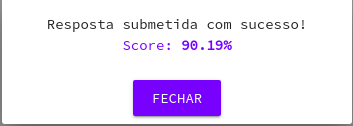

In [44]:
Image('imagens/score3.png')

- RandomForestRegressor:

In [45]:
CV_pipe_RFR.fit(x_train, y_train)
ypred = CV_pipe_RFR.predict(x_test)

/home/gabriela/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [46]:
df_result['NU_NOTA_MT'] = np.around(ypred2,2)

In [47]:
df_result.to_csv('answer4.csv', index=False, header=True)

Essa predição já gerou um score melhor em relação ao GradientBoost, com a taxa de acertos de 93.46%

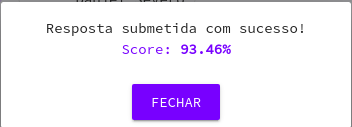

In [48]:
Image('imagens/score4.png')

## Conclusão

Os dois modelos tiveram performances bem parecidas, porém para esse desafio foi utilizada a resposta final do GradientBoost por ter um score um pouco maior e ser melhor para a nota de corte de participação da aceleração. Por ser um problema mais simples não foram necessários testes com hyperparâmetros e outras formas de normalizações por exemplo.